In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import files
import shutil
from google.colab.patches import cv2_imshow

In [ ]:
# Upload files
print("Please upload the CSV file:")
uploaded_csv = files.upload()

Please upload the CSV file:


Saving labels_my-project-name_2024-10-16-05-22-11.csv to labels_my-project-name_2024-10-16-05-22-11.csv


In [ ]:
print("Please upload the images (as a zip file or individually):")
uploaded_images = files.upload()

Please upload the images (as a zip file or individually):


Saving 00d4450e-2571-4055-906f-d9236333fc0b_jpg.rf.2d1c324457d21bd605f036c88de4d68f.jpg to 00d4450e-2571-4055-906f-d9236333fc0b_jpg.rf.2d1c324457d21bd605f036c88de4d68f.jpg
Saving 00d4450e-2571-4055-906f-d9236333fc0b_jpg.rf.8e15c680da12cdb80159f6761a16d535.jpg to 00d4450e-2571-4055-906f-d9236333fc0b_jpg.rf.8e15c680da12cdb80159f6761a16d535.jpg
Saving 00d4450e-2571-4055-906f-d9236333fc0b_jpg.rf.fccc1f767fbdb62cf091fc2c47bb60a4.jpg to 00d4450e-2571-4055-906f-d9236333fc0b_jpg.rf.fccc1f767fbdb62cf091fc2c47bb60a4.jpg
Saving 00eb59e1-ee3d-4ea4-81be-2698eeb9018d_jpg.rf.619bcf25e4be5f348fa694693afd0888.jpg to 00eb59e1-ee3d-4ea4-81be-2698eeb9018d_jpg.rf.619bcf25e4be5f348fa694693afd0888.jpg
Saving 00eb59e1-ee3d-4ea4-81be-2698eeb9018d_jpg.rf.94923a5df387a68eee1e0196d0dc7698.jpg to 00eb59e1-ee3d-4ea4-81be-2698eeb9018d_jpg.rf.94923a5df387a68eee1e0196d0dc7698.jpg
Saving 00eb59e1-ee3d-4ea4-81be-2698eeb9018d_jpg.rf.fc587ef42242a223d347db74c232d48f.jpg to 00eb59e1-ee3d-4ea4-81be-2698eeb9018d_jpg.rf.fc587

In [ ]:
# If the images are uploaded as a zip, unzip the file
if len(uploaded_images) == 1 and list(uploaded_images.keys())[0].endswith('.zip'):
    import zipfile
    with zipfile.ZipFile(list(uploaded_images.keys())[0], 'r') as zip_ref:
        zip_ref.extractall('/content/images/')
    image_folder_path = '/content/images/Nikhil'
else:
    # Otherwise, move the images to a folder
    os.makedirs('images', exist_ok=True)
    for filename, content in uploaded_images.items():
        with open(os.path.join('images', filename), 'wb') as f:
            f.write(content)
    image_folder_path = 'images/'

# Load the uploaded CSV file
csv_filename = list(uploaded_csv.keys())[0]
csv_file_path = f'/content/{csv_filename}'

def load_csv_data(csv_file):
    data = pd.read_csv(csv_file)
    return data

# Load data from the CSV
data = load_csv_data(csv_file_path)

In [ ]:
def preprocess_image(image_path, bbox, target_size=(256, 256)):
    # Load the image
    image = cv2.imread(image_path)
    original_height, original_width = image.shape[:2]

    # Normalize bounding box coordinates relative to the image size
    x_min = bbox['bbox_x'] / original_width
    y_min = bbox['bbox_y'] / original_height
    x_max = (bbox['bbox_x'] + bbox['bbox_width']) / original_width
    y_max = (bbox['bbox_y'] + bbox['bbox_height']) / original_height

    # Resize image to target size for the model
    image = cv2.resize(image, target_size)

    # Normalize image values to range [0, 1]
    image = image.astype(np.float32) / 255.0

    # Return the preprocessed image and the normalized bounding box
    return image, np.array([x_min, y_min, x_max, y_max])

def compile_rcnn_model(model):
    # Compile the model
    model.compile(
        optimizer='adam',
        loss={
            'classification_output': 'binary_crossentropy',  # Loss for binary classification
            'bbox_output': 'mean_squared_error'  # Loss for bounding box regression
        },
        metrics={
            'classification_output': 'accuracy'
        }
    )

def generate_training_data(data, image_folder, target_size=(256, 256)):
    images = []
    class_labels = []
    bboxes = []

    for index, row in data.iterrows():
        image_name = row['image_name']
        image_path = os.path.join(image_folder, image_name)

        # Preprocess image and bounding box
        image, bbox = preprocess_image(image_path, row, target_size)
        images.append(image)

        # Class label: 1 for empty space, 0 for non-empty space
        class_label = 1 if row['label_name'] == 'empty-shelf' else 0
        class_labels.append(class_label)

        # Append the bounding box
        bboxes.append(bbox)

    return np.array(images), np.array(class_labels), np.array(bboxes)

# Generate the training data
X_train, Y_train_class, Y_train_bbox = generate_training_data(data, image_folder_path)

In [ ]:
def build_base_cnn(input_tensor):
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_tensor)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    return x

def build_rcnn_model(input_shape):
    # Input tensor for the images
    input_tensor = Input(shape=input_shape)

    # Pass the input tensor through the base CNN
    base_cnn_output = build_base_cnn(input_tensor)

    # Binary classification head (sigmoid for empty class detection)
    classification_output = layers.Dense(1, activation='sigmoid', name="classification_output")(base_cnn_output)

    # Bounding box regression head (4 values for bounding box coordinates)
    bbox_output = layers.Dense(4, name="bbox_output")(base_cnn_output)

    # Create the final model
    model = models.Model(inputs=input_tensor, outputs=[classification_output, bbox_output])

    return model

def compile_rcnn_model(model):
    # Compile the model
    model.compile(
        optimizer='adam',
        loss={
            'classification_output': 'binary_crossentropy',  # Loss for binary classification
            'bbox_output': 'mean_squared_error'  # Loss for bounding box regression
        },
        metrics={
            'classification_output': 'accuracy'
        }
    )

# Assume input images are of shape 128x128x3 and we have 2 classes (empty or not empty)
input_shape = (256, 256, 3)
num_classes = 2

# Build and compile the RCNN model
rcnn_model = build_rcnn_model(input_shape)
compile_rcnn_model(rcnn_model)

# Train the model
rcnn_model.fit(X_train,
               {'classification_output': Y_train_class, 'bbox_output': Y_train_bbox},
               epochs=3, batch_size=8)

Epoch 1/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - classification_output_accuracy: 1.0000 - loss: 8.2688
Epoch 2/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - classification_output_accuracy: 1.0000 - loss: 0.0794
Epoch 3/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - classification_output_accuracy: 1.0000 - loss: 0.0807


In [ ]:
def segment_image(image_path, threshold=128):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Apply a binary threshold to segment the black and white areas
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY_INV)

    return binary_image


In [ ]:
def detect_empty_area(binary_image, model, original_image, target_size=(256, 256), threshold_width=20, threshold_height=20):
    # Find contours in the binary image to get bounding regions around black areas
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Draw bounding box only on black areas if they exceed certain dimensions
        if w > threshold_width and h > threshold_height:
            cv2.rectangle(original_image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw bounding box in blue
            cv2.putText(original_image, 'empty', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return original_image


Please upload a test image:


Saving 00eb59e1-ee3d-4ea4-81be-2698eeb9018d_jpg.rf.619bcf25e4be5f348fa694693afd0888.jpg to 00eb59e1-ee3d-4ea4-81be-2698eeb9018d_jpg.rf.619bcf25e4be5f348fa694693afd0888 (8).jpg


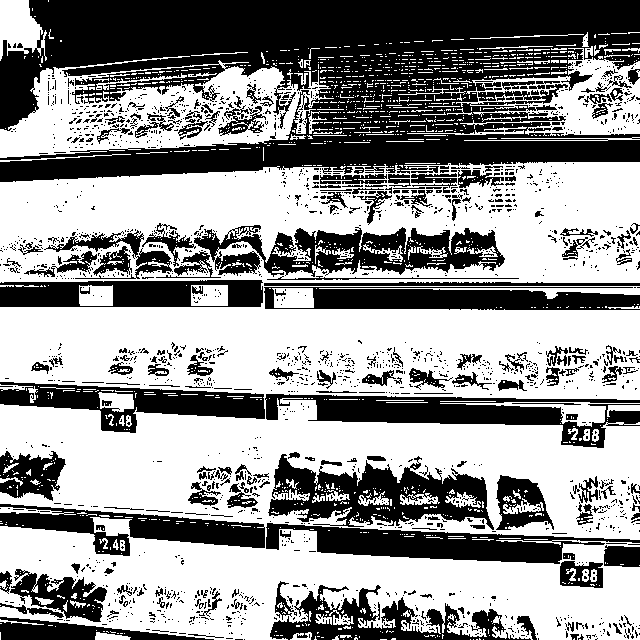

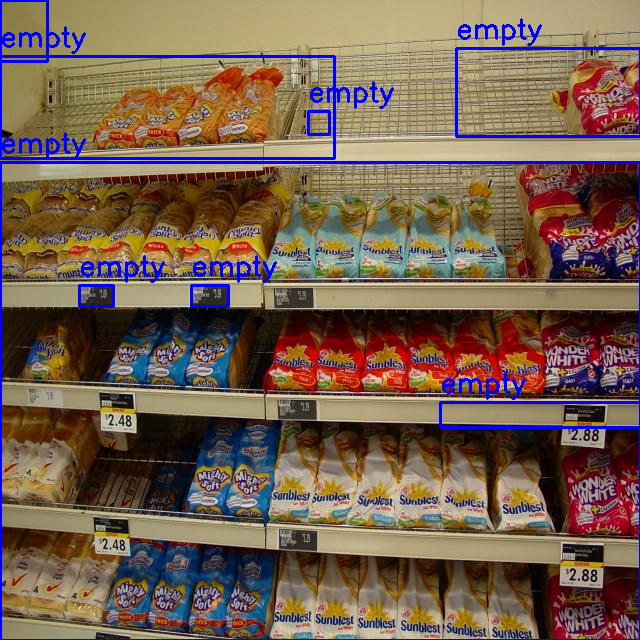

In [ ]:
def predict_on_image(image_path, model, target_size=(256, 256)):
    # Preprocess the input image
    original_image = cv2.imread(image_path)

    # Define output path for the segmented image

    # Step 1: Segment the image
    binary_image = segment_image(image_path)

    cv2_imshow(binary_image)
    # Step 2: Detect empty areas in the binary image
    result_image = detect_empty_area(binary_image, model, original_image)

    # Display the result
    cv2_imshow(result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



# Example usage
print("Please upload a test image:")
test_image = files.upload()
test_image_path = list(test_image.keys())[0]

# Predict on the new image
predict_on_image(test_image_path, rcnn_model)